In [ ]:
# Import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import urllib.request # to import images from dataset
import sys

from sklearn.model_selection import train_test_split


In [ ]:
# Import Neural Network and PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
from google.colab import drive
#files.upload()

In [ ]:
!mdkir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: mdkir: command not found
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d vanshikavmittal/fakeddit-dataset

Dataset URL: https://www.kaggle.com/datasets/vanshikavmittal/fakeddit-dataset
License(s): unknown
 95% 69.0M/72.8M [00:01<00:00, 70.4MB/s]
100% 72.8M/72.8M [00:01<00:00, 57.8MB/s]


In [ ]:
!unzip /content/fakeddit-dataset.zip -d /content/fakeddit-dataset

Archive:  /content/fakeddit-dataset.zip
  inflating: /content/fakeddit-dataset/multimodal_only_samples/multimodal_test_public.tsv  
  inflating: /content/fakeddit-dataset/multimodal_only_samples/multimodal_train.tsv  
  inflating: /content/fakeddit-dataset/multimodal_only_samples/multimodal_validate.tsv  


In [ ]:
import os
dataset_path = "/content/fakeddit-dataset/multimodal_only_samples"
print("Path to dataset files:" , os.listdir(dataset_path))

Path to dataset files: ['multimodal_train.tsv', 'multimodal_test_public.tsv', 'multimodal_validate.tsv']


In [ ]:
import glob
tsv_files = glob.glob(os.path.join(dataset_path, "*.tsv"))
print("Number of tsv files:" , len(tsv_files))

Number of tsv files: 3


In [ ]:
df = pd.read_csv('/content/fakeddit-dataset/multimodal_only_samples/multimodal_train.tsv', sep='\t')


In [ ]:
df.shape

(564000, 16)

In [ ]:
df, _ = train_test_split(
    df,
    test_size=0.97,
    shuffle=True,
    stratify=df["6_way_label"],
    random_state=42,
)

In [ ]:
df.shape

(16920, 16)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
print("clean_title:", df["clean_title"].isnull().sum())
print("has_image:", df["hasImage"].isnull().sum())
print("id:", df["id"].isnull().sum())

# Check how many rows with the column "hasImage" is false
print("\n", df["hasImage"].value_counts())

clean_title: 0
has_image: 0
id: 0

 hasImage
True    16920
Name: count, dtype: int64


<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

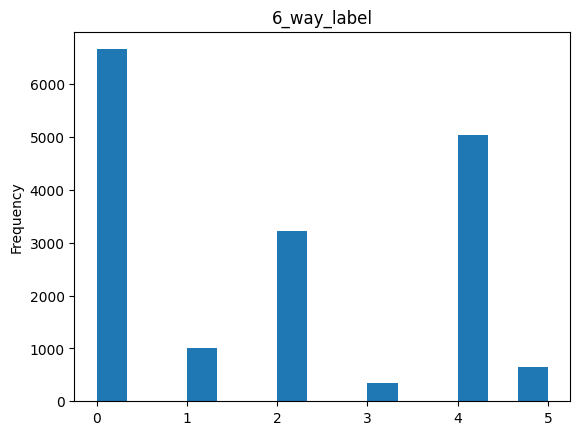

In [ ]:
df["6_way_label"].plot(kind="hist", bins = 15, title = "6_way_label")

In [ ]:
import os
import numpy as np
from urllib import request
from concurrent.futures import ThreadPoolExecutor , as_completed

In [ ]:
df = df.replace(np.nan, '', regex=True)
df.fillna("",inplace = True)

In [ ]:
image_dir = "/content/Images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir,exist_ok=True)

In [ ]:
# Get a list of all image file paths (adjust file extensions if needed)
all_images_files = [
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith((",jpg","jpeg",".png"))
    ]
print("Total images available:", len(all_images_files))

Total images available: 0


In [ ]:
subset_size = 10000

In [ ]:
df

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Vranak,president assad expresses appreciation towards...,1.388330e+09,cnn.com,True,1txzm9,https://external-preview.redd.it/k3pMa3DrphExz...,,2.0,13,upliftingnews,President Assad expresses appreciation towards...,0.82,1,0,0
1,monkeypowah,uk policeman asks for names and addresses of p...,1.423516e+09,theguardian.com,True,2vcb92,https://external-preview.redd.it/72WISwugE1C3P...,,1.0,27,nottheonion,UK policeman asks for names and addresses of p...,0.88,1,0,0
2,Relandis,flypocalypse dad swatted these flies in the ki...,1.564338e+09,i.redd.it,True,ciz7vl,https://preview.redd.it/v6t5ktde53d31.jpg?widt...,,3.0,4,mildlyinteresting,Flypocalypse - Dad swatted these flies in the ...,0.63,1,0,0
3,dwaxe,life times pixar movies made us cry like babies,1.470069e+09,clickhole.com,True,4vnbj9,https://external-preview.redd.it/LNyLFwFIi6Knk...,,0.0,5,theonion,Life: 9 Times Pixar Movies Made Us Cry Like Ba...,0.67,0,2,1
4,SowerPlave,stay classy tiger,1.378134e+09,,True,cc084wv,http://i.imgur.com/IqgTf87.jpg,1lkj8g,,6,psbattle_artwork,"Stay classy, Tiger!",,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16915,piedmont6,after transplant saves her son mom returns the...,1.405109e+09,newser.com,True,2agd8x,https://external-preview.redd.it/BRsICYmjMl0FE...,,0.0,14,upliftingnews,"After Transplant Saves Her Son, Mom Returns th...",0.84,1,0,0
16916,Pooch76,dog in a field,1.503420e+09,i.redd.it,True,6vc7fu,https://preview.redd.it/qqari2mtgbhz.jpg?width...,,4.0,3,photoshopbattles,PsBattle: Dog in a field,1.0,1,0,0
16917,SomeGuyInNewZealand,police escort surgeon through auckland rush ho...,1.502103e+09,stuff.co.nz,True,6s4rmk,https://external-preview.redd.it/XZzRiIuvTT1xu...,,0.0,16,upliftingnews,Police escort surgeon through Auckland rush ho...,0.85,1,0,0
16918,SiON42X,garth brooks gives unexpected answer to trump ...,1.484687e+09,archive.is,True,5okrm9,https://external-preview.redd.it/auG2N6WhVRaFa...,,7.0,104,savedyouaclick,Garth Brooks Gives Unexpected Answer To Trump ...,0.89,0,2,5


In [ ]:
df.drop(["2_way_label","3_way_label","title"],axis=1 , inplace=True)

In [ ]:
df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,Vranak,president assad expresses appreciation towards...,1.388330e+09,cnn.com,True,1txzm9,https://external-preview.redd.it/k3pMa3DrphExz...,,2.0,13,upliftingnews,0.82,0
1,monkeypowah,uk policeman asks for names and addresses of p...,1.423516e+09,theguardian.com,True,2vcb92,https://external-preview.redd.it/72WISwugE1C3P...,,1.0,27,nottheonion,0.88,0
2,Relandis,flypocalypse dad swatted these flies in the ki...,1.564338e+09,i.redd.it,True,ciz7vl,https://preview.redd.it/v6t5ktde53d31.jpg?widt...,,3.0,4,mildlyinteresting,0.63,0
3,dwaxe,life times pixar movies made us cry like babies,1.470069e+09,clickhole.com,True,4vnbj9,https://external-preview.redd.it/LNyLFwFIi6Knk...,,0.0,5,theonion,0.67,1
4,SowerPlave,stay classy tiger,1.378134e+09,,True,cc084wv,http://i.imgur.com/IqgTf87.jpg,1lkj8g,,6,psbattle_artwork,,4


In [ ]:
df = df[df["hasImage"] == True].copy()
df = df[df["image_url"].notna()].copy()

In [ ]:
from torchvision import transforms
from io import BytesIO
import requests
from tqdm.notebook import tqdm


In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def load_and_preprocess_image(image_url):
    try:
        # Download the image
        response = requests.get(image_url, timeout=10)
        response.raise_for_status()  # raise an exception for HTTP errors
        # Open and convert the image to RGB
        img = Image.open(BytesIO(response.content)).convert('RGB')
        # Apply the transformation pipeline
        img_tensor = image_transforms(img)
        return img_tensor
    except Exception as e:
        print(f"Error processing image from {image_url}: {e}")
        return None

In [ ]:
'''tqdm.pandas(desc="Processing images")
df['processed_image'] = df['image_url'].progress_apply(load_and_preprocess_image)


SyntaxError: incomplete input (<ipython-input-32-a478b03bbedb>, line 1)

In [ ]:
'''!zip -r images.zip /content/Images

In [ ]:
'''from google.colab import files
files.download("images.zip")

In [ ]:

import torch

df.to_pickle("processed_df.pkl")


In [ ]:
print("Total rows with images:", len(df))
print("Number of successfully processed images:", df['processed_image'].notna().sum())

In [ ]:
"""
_def download_image(row):
    image_url = row["image_url"]
    image_path = os.path.join(image_dir, f"{row['id']}.jpg")  # Save with ID as filename

    try:
        with request.urlopen(image_url) as response:
            with open(image_path, "wb") as f:
                f.write(response.read())
        return image_path  # Successfully downloaded
    except Exception as e:
        print(f"Failed to download {image_url}: {e}")
        return False  # Return False on failure

def process_row(index, row):
    if row["hasImage"] and isinstance(row["image_url"], str) and row["image_url"].strip():
        success = download_image(row)
        if not success:
            return index
    return None

failed_indices = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(process_row, index, row): index for index, row in df.iterrows()}

    for future in as_completed(futures):
        index = futures[future]
        try:
            failed_index = future.result()
            if failed_index is not None:
                failed_indices.append(failed_index)
        except Exception as exc:
            print(f"An error occurred for row {index}: {exc}")

# Remove failed downloads from DataFrame
df.drop(index=failed_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

print("Downloaded all images successfully.")

In [ ]:
'''!zip -r images.zip . -i /content/Images

In [ ]:
from google.colab import files
files.download("/content/Images")

In [ ]:
df.head()